**<h3><center>EN2550 Exercise 9 - Structure from Motion</center></h3>**
*Name - Abeysinghe W.A.M.S.Y*
<br>
*Index no - 190014F*
<br>

All the imports are done at the beginning. 

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

The Middlebury Multi-View Stereo dataset contains calibrated image. Read the webpage
and download the TempleSparseRing 1 dataset, if you have not done so in the last
exercise. As done last week, read in the templeSR_par.txtg and populate the parameters of
Ki Ri and ti for i = 1,2. Compute the camera matrices Pi for i = 1,2.

**Q1**. Find SIFT features in the two images ( sift = cv.xfeatures2d.SIFT_create()) and match
them using the Flann-based descriptor matcher.

In [2]:
s = open('templeSparseRing/templeSR_par.txt','r')
assert s is not None
n = int(s.readline())
#first img
l = s.readline().split()
im1_fn = l[0]
K1 = np.array([float(i) for i in l[1:10]]).reshape((3,3))
R1 = np.array([float(i) for i in l[10:19]]).reshape((3,3))
t1 = np.array([float(i) for i in l[19:22]]).reshape((3,1))
#second img 
l = s.readline().split()
im2_fn = l[0]
K2 = np.array([float(i) for i in l[1:10]]).reshape((3,3))
R2 = np.array([float(i) for i in l[10:19]]).reshape((3,3))
t2 = np.array([float(i) for i in l[19:22]]).reshape((3,1))
im1 = cv.imread('templeSparseRing/'+ im1_fn, cv.IMREAD_COLOR)
im2 = cv.imread('templeSparseRing/'+ im2_fn, cv.IMREAD_COLOR)
assert im1 is not None
assert im2 is not None

**Q2**. Compute the fundamental matrix F and the essential matrix E.

In [3]:
sift = cv.xfeatures2d.SIFT_create()
kp1,desc1 = sift.detectAndCompute(im1,None)
kp2,desc2 = sift.detectAndCompute(im2,None)
FLANN_INDEX_KDTREF = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREF,trees = 5)
search_params = dict(checks=100)
flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(desc1,desc2, k = 2)
good = []
pts1 = []
pts2 = []
for i,(m,n) in enumerate (matches):
    if m.distance < 0.7*n.distance:
        good.append(m)
        pts1.append(kp1[m.queryIdx].pt)
        pts2.append(kp2[m.trainIdx].pt)

pts1 = np.array(pts1)
pts2 = np.array(pts2)
F,mask = cv.findFundamentalMat(pts1,pts2,cv.FM_RANSAC)
E = K2.T @ F @ K1
retval,R,t,mask = cv.recoverPose(E,pts1,pts2,K1)

**Q3**. Use recoverPose method to recover the pose of the second camera with respect to the
first, i.e., R and t

In [4]:
retval,R,t,mask = cv.recoverPose(E,pts1,pts2,K1)

**Q4**. Computer the cameras matrix P2. (Disregard that we already have this from the
dataset.)

In [5]:
R_t_1 = np.concatenate((R1,t1),axis = 1)
R_t_2 = np.empty((3,4))
R2_ = R1@R
t2_ = R1@t
R_t_2 = np.concatenate((R2_,t2_),axis = 1)

P1 = K1 @ np.hstack((R1,t1)) 
P2_ = K2 @ R_t_2

**Q5**. Find the 3-D point locations using triangulatePoints method. Plot these points.

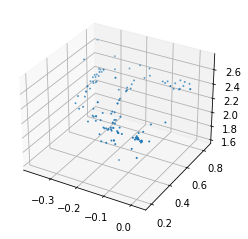

In [6]:
points4d = cv.triangulatePoints(P1,P2_,pts1.T,pts2.T)
points4d /= points4d[3,:]
x = points4d[0,:]
y = points4d[1,:]
z = points4d[2,:]
fig = plt.figure(1)
ax = fig.add_subplot(111,projection = '3d')
ax.scatter(x,y,z,s = 1,cmap = 'gray')
plt.show()